In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import shutil
import sys   
from glob import glob
import re
import os
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
import sys
import datetime
from threading import Lock

from prettytable import PrettyTable

def log(str):
    print(str, file=sys.stderr)
    sys.stderr.flush()

class ResultWriter:
    def __init__(self, results_filename):
        self.results_filename = results_filename
        self.lock = Lock()

    def write(self, str):
        self.lock.acquire()
        try:
            with open(self.results_filename +'.txt', "a", encoding="utf-8") as f:
                f.write(str + "\n")
        finally:
            self.lock.release()

    def log(self, msg):
        timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
        msg = timestamp + ": " + msg
        log(msg)
        self.lock.acquire()
        try:
            with open(self.results_filename + ".log", "a", encoding="utf-8") as f:
                f.write(msg + "\n")
        finally:
            self.lock.release()


def get_num_model_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])


def print_model_parameters(model,rw):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, f'{param:,}'])
        total_params += param
    rw.log(f'{table}')
    rw.log(f"Total Trainable Params: {total_params}")
    return total_params

rw = ResultWriter('./logs/bert_base_uncased_append_sentence_three_append_labels_CE_loss_presentation')

In [3]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len,ohe):
        self.tokenizer = tokenizer
        self.df = df
        self.ohe = ohe
        self.title = df['text']
        self.targets = self.ohe.transform(np.array(self.df.label.values).reshape(-1,1)).toarray()
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        #title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [4]:
class BERTClass(torch.nn.Module):
    def __init__(self,pre_trained):
        super(BERTClass, self).__init__()
        self.bert_model = AutoModel.from_pretrained(pre_trained)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 13)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear1(output_dropout)
        return output
    
    """def pool_hidden_state(self, last_hidden_state):
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state"""

In [5]:
class GlobalMaxPooling1D(torch.nn.Module):
    def __init__(self, data_format='channels_last'):
        super(GlobalMaxPooling1D, self).__init__()
        self.data_format = data_format
        self.step_axis = 1 if self.data_format == 'channels_last' else 2

    def forward(self, input):
        return torch.max(input, axis=self.step_axis).values

class BERTCNN(torch.nn.Module):
    def __init__(self,pre_trained):
        super(BERTCNN, self).__init__()
        self.bert_model = AutoModel.from_pretrained(pre_trained)
        
        self.conv1 = torch.nn.Conv1d(256, 128, kernel_size=5)
        self.conv2 = torch.nn.Conv1d(256, 128, kernel_size=10)
        self.mp = GlobalMaxPooling1D('channels_first')
        self.bn = torch.nn.BatchNorm1d(128)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(128, 64)
        self.linear2 = torch.nn.Linear(128, 64)
        self.linear3 = torch.nn.Linear(128,13)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        X = self.conv1(output.last_hidden_state)
        X = self.mp(X)
        #print(X.shape)
        X = self.bn(X)
        #print(X.shape)
        X = F.relu(self.linear1(X))
        Y = self.conv2(output.last_hidden_state)
        Y = self.mp(Y)
        Y = self.bn(Y)
        Y = F.relu(self.linear2(Y))
        concat = torch.concat((X,Y),dim=1)
        output = self.dropout(concat)
        output = self.linear3(output)
        #output_dropout = self.dropout(output.pooler_output)
        #output = self.linear(output_dropout)
        return output

In [5]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [6]:
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
  val_targets = []
  val_outputs = []

  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
   
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('# Epoch {}: #'.format(epoch),end='\t')
    for batch_idx, data in enumerate(tqdm(training_loader)):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device,dtype=torch.float)
        
        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)#focal_loss(outputs, targets)
        #print(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(tqdm(validation_loader, 0)):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            
      
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      rw.log('epoch:{:.6f} Avg Training Loss: {:.6f} \tAvg Validation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
      # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        rw.log('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('\t Done\n'.format(epoch))

  return model

In [7]:
#it'll return true and predicted labels
def predict(data_loader,model):
    target_list = []
    output_list = []
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(data_loader, 0)):
          ids = data['input_ids'].to(device, dtype = torch.long)
          mask = data['attention_mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)
          outputs = model(ids, mask, token_type_ids)
          target_list.extend(targets.cpu().detach().numpy().tolist())
          output_list.extend(F.softmax(outputs,dim=1).cpu().detach().numpy().tolist())
    return np.array(target_list).argmax(1),np.array(output_list).argmax(1)

In [8]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [9]:
pretrained_name = "bert-base-uncased"

# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 1e-05

rw.log(f'pretrained_name: {pretrained_name}')
rw.log(f'MAX_LEN: {MAX_LEN}')
rw.log(f'BATCH_SIZE: {TRAIN_BATCH_SIZE}')
rw.log(f'EPOCHS: {EPOCHS}')
rw.log(f'LEARNING RATE: {LEARNING_RATE}')

2022-05-02 23:11:56.736: pretrained_name: bert-base-uncased
2022-05-02 23:11:56.739: MAX_LEN: 256
2022-05-02 23:11:56.740: BATCH_SIZE: 4
2022-05-02 23:11:56.741: EPOCHS: 5
2022-05-02 23:11:56.742: LEARNING RATE: 1e-05


In [10]:
f = glob('./data/*.csv')
f

['./data\\train_data.csv',
 './data\\train_data_append_label.csv',
 './data\\train_data_append_sentence.csv',
 './data\\train_data_append_sentence_four_append_labels.csv',
 './data\\train_data_append_sentence_new_preprocess.csv',
 './data\\train_data_append_sentence_three.csv',
 './data\\train_data_append_sentence_three_append_labels.csv',
 './data\\train_data_append_sentence_three_append_labels_no_sep.csv',
 './data\\val_data.csv',
 './data\\val_data_append_sentence.csv',
 './data\\val_data_append_sentence_new_preprocess.csv',
 './data\\val_data_append_sentence_three.csv']

In [11]:
train_path = f[6]#'./data/train_data_append_sentence_three.csv' 
#test_path = f[8]#'./data/val_data_append_sentence.csv'
train_df = pd.read_csv(train_path)
#test_df = pd.read_csv(test_path)
target_list = list(train_df.label.unique())
target_list.sort()
ohe = OneHotEncoder()
ohe.fit(np.array(target_list).reshape(-1,1))

train_df = train_df.drop(columns=['id','start','end'])
#test_df = test_df.drop(columns=['id','start','end'])

train_df, val_df = train_test_split(train_df, test_size=0.2)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [12]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_name)

In [13]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN,ohe)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN,ohe)
#test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN,ohe)

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0)
val_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=0)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
rw.log(f'device: {device}')

2022-05-02 23:12:44.200: device: cuda


In [15]:
classifier_name = 'linear_layer_append_sentences_three_append_labels_CE_loss_presentation'
dir_path = "./trained_weights/" +pretrained_name+'/'+ classifier_name 
rw.log(f'pretrained name: {pretrained_name}')
rw.log(f'classifier name: {classifier_name}')
rw.log(f'trained weights path: {dir_path}')

if not os.path.exists(dir_path):  
  os.makedirs(dir_path)
  print(f"The new directory is created: {dir_path}")
    
ckpt_path = dir_path+"/current_checkpoint.pt"
best_model_path = dir_path+"/best_model.pt"

2022-05-02 23:12:54.621: pretrained name: bert-base-uncased
2022-05-02 23:12:54.622: classifier name: linear_layer_append_sentences_three_append_labels_CE_loss_presentation
2022-05-02 23:12:54.622: trained weights path: ./trained_weights/bert-base-uncased/linear_layer_append_sentences_three_append_labels_CE_loss_presentation


The new directory is created: ./trained_weights/bert-base-uncased/linear_layer_append_sentences_three_append_labels_CE_loss_presentation


In [16]:
model = BERTClass(pretrained_name)
model.to(device)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [26]:
##Load Model
try:
    if(os.path.exists(best_model_path)):
        model, optimizer, epoch_val, valid_loss_min = load_ckp(best_model_path, model, optimizer)
    elif(os.path.exists(ckpt_path)):
        model, optimizer, epoch_val, valid_loss_min = load_ckp(ckpt_path, model, optimizer)
except:
    print('no model exist')

In [17]:
model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

# Epoch 1: #	

100%|████████████████████████████████████████████████████████████████████████████████| 964/964 [00:25<00:00, 38.05it/s]
2022-05-02 23:19:48.278: epoch:1.000000 Avg Training Loss: 0.000030 	Avg Validation Loss: 0.000071
2022-05-02 23:19:50.880: Validation loss decreased (inf --> 0.000071).  Saving model ...


	 Done

# Epoch 2: #	

100%|████████████████████████████████████████████████████████████████████████████████| 964/964 [00:25<00:00, 38.52it/s]
2022-05-02 23:26:33.024: epoch:2.000000 Avg Training Loss: 0.000016 	Avg Validation Loss: 0.000054
2022-05-02 23:26:35.005: Validation loss decreased (0.000071 --> 0.000054).  Saving model ...


	 Done

# Epoch 3: #	

100%|████████████████████████████████████████████████████████████████████████████████| 964/964 [00:25<00:00, 38.55it/s]
2022-05-02 23:33:13.897: epoch:3.000000 Avg Training Loss: 0.000011 	Avg Validation Loss: 0.000051
2022-05-02 23:33:15.864: Validation loss decreased (0.000054 --> 0.000051).  Saving model ...


	 Done

# Epoch 4: #	

100%|████████████████████████████████████████████████████████████████████████████████| 964/964 [00:25<00:00, 38.45it/s]
2022-05-02 23:39:56.388: epoch:4.000000 Avg Training Loss: 0.000008 	Avg Validation Loss: 0.000050
2022-05-02 23:39:58.311: Validation loss decreased (0.000051 --> 0.000050).  Saving model ...


	 Done

# Epoch 5: #	

100%|████████████████████████████████████████████████████████████████████████████████| 964/964 [00:25<00:00, 38.18it/s]
2022-05-02 23:46:38.090: epoch:5.000000 Avg Training Loss: 0.000006 	Avg Validation Loss: 0.000056


	 Done



In [18]:
#train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
#val_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=0)
train_true,train_pred = predict(train_data_loader,model)
val_true,val_pred = predict(val_data_loader,model)
train_clf = classification_report(train_true,train_pred,zero_division=True,output_dict = True,target_names=target_list)
val_clf = classification_report(val_true,val_pred,zero_division=True,target_names=target_list,output_dict=True)
rw.log(f'{"_"*30}Training Results{"_"*30}\n')
rw.log(classification_report(train_true,train_pred,zero_division=True,target_names=target_list))
rw.log(f'{"_"*30}Val Results{"_"*30}\n')
rw.log(classification_report(val_true,val_pred,zero_division=True,target_names=target_list))

100%|████████████████████████████████████████████████████████████████████████████████| 964/964 [00:25<00:00, 38.54it/s]
2022-05-02 23:48:45.414: ______________________________Training Results______________________________

2022-05-02 23:48:45.432:                 precision    recall  f1-score   support

      ANALYSIS       0.99      0.98      0.99      5364
ARG_PETITIONER       0.96      0.99      0.98       712
ARG_RESPONDENT       0.96      0.95      0.96       339
           FAC       0.99      0.99      0.99      2853
         ISSUE       0.96      0.96      0.96       207
          NONE       0.98      0.97      0.97       892
      PREAMBLE       0.99      1.00      1.00      2506
PRE_NOT_RELIED       0.86      0.64      0.73        75
    PRE_RELIED       0.94      0.98      0.96       750
         RATIO       0.91      0.88      0.89       361
           RLC       0.96      0.97      0.97       435
           RPC       0.95      0.99      0.97       673
           STA       0.

In [1]:
import re
def preprocess(text):
    return re.sub('\W+',' ', re.sub('\n',' ',text))

import json
test_true = []
test_pred = []
model.eval()
test_data = json.loads(open('./data/val_data.json').read())
for i in tqdm(test_data):  
    index = 0
    for j in (range(len(i['annotations'][0]['result']))): 
        if(index == 0):
            prev_1 = ''
            prev_2 = ''
            prev_3 = ''
            pl_1 = '[UNK]'
            pl_2 = '[UNK]'
            pl_3 = '[UNK]'            
        elif(index==1):
            prev_1 = ''
            prev_2 = ''
            prev_3 = preprocess(i['annotations'][0]['result'][j-1]['value']['text'])
            pl_1 = '[UNK]'
            pl_2 = '[UNK]'
            pl_3 = target_list[test_pred[-1][0]]#i['annotations'][0]['result'][j-1]['value']['labels'][0]
        elif(index==2):
            prev_1 = ''
            prev_2 = preprocess(i['annotations'][0]['result'][j-2]['value']['text'])
            prev_3 = preprocess(i['annotations'][0]['result'][j-1]['value']['text'])
            pl_1 = '[UNK]'
            pl_2 = target_list[test_pred[-2][0]]#i['annotations'][0]['result'][j-2]['value']['labels'][0]
            pl_3 = target_list[test_pred[-1][0]]#i['annotations'][0]['result'][j-1]['value']['labels'][0]
        else:
            prev_1 = preprocess(i['annotations'][0]['result'][j-3]['value']['text'])
            prev_2 = preprocess(i['annotations'][0]['result'][j-2]['value']['text'])
            prev_3 = preprocess(i['annotations'][0]['result'][j-1]['value']['text'])
            pl_1 = target_list[test_pred[-3][0]]#i['annotations'][0]['result'][j-3]['value']['labels'][0]
            pl_2 = target_list[test_pred[-2][0]]#i['annotations'][0]['result'][j-2]['value']['labels'][0] 
            pl_3 = target_list[test_pred[-1][0]]#i['annotations'][0]['result'][j-1]['value']['labels'][0]

        a = preprocess(i['annotations'][0]['result'][j]['value']['text'])
        #if(a!=''):
        s = pl_1 + '[SEP]' + pl_2 + '[SEP]' +pl_3 + '[SEP]' + prev_1 + '[SEP]' + prev_2 + '[SEP]'  + prev_3 + '[SEP]' +  a #preprocess(i['annotations'][0]['result'][j]['value']['text'])
        #s = pl_1 + ' ' + pl_2 + ' ' +pl_3 + ' ' + prev_1 + ' ' + prev_2 + ' '  + prev_3 + ' ' +  a #preprocess(i['annotations'][0]['result'][j]['value']['text'])
        text = s
        text_encode = tokenizer.encode_plus(
                text,
                None,
                add_special_tokens=True,
                max_length=MAX_LEN,
                padding='max_length',
                return_token_type_ids=True,
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
        input_ids = text_encode['input_ids'].to(device)
        token_type_ids = text_encode['token_type_ids'].to(device)
        attention_mask = text_encode['attention_mask'].to(device)
        output = model(input_ids, attention_mask, token_type_ids)
        test_pred.append(F.softmax(output,dim=1).cpu().detach().numpy().argmax(1))
        test_true.append(i['annotations'][0]['result'][j]['value']['labels'][0])
        index+=1
            
        
test_pred = np.array(test_pred).reshape(1,-1)[0]    
test_true = ohe.transform(np.array(test_true).reshape(-1,1)).toarray().argmax(1)

NameError: name 'model' is not defined

In [ ]:
test_clf = classification_report(test_true,test_pred,zero_division=True,target_names=target_list,output_dict=True)
rw.log(f'{"_"*30}Test Results{"_"*30}\n')
rw.log(classification_report(test_true,test_pred,zero_division=True,target_names=target_list))

<IPython.core.display.Javascript object>

<AxesSubplot:>

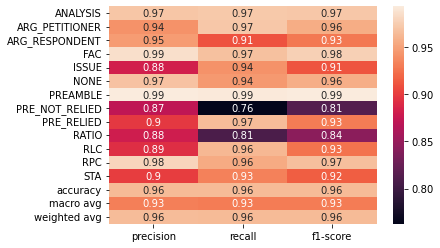

In [32]:
sns.heatmap(pd.DataFrame(train_clf).iloc[:-1, :].T, annot=True)

<IPython.core.display.Javascript object>

<AxesSubplot:>

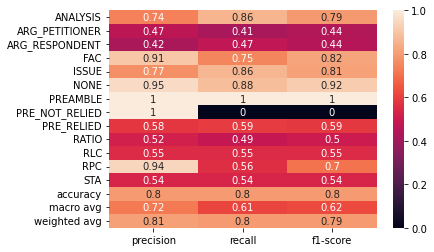

In [33]:
sns.heatmap(pd.DataFrame(test_clf).iloc[:-1, :].T, annot=True)